1. Read temperature and wind dataset
2. Extract the points cross the shore in the defined rectanglur grid
3. rotate the wind field according to the rectanguler grid coordinate.

## Import Modules

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import numpy as np
from shapely import Point, LineString
import fiona
from tqdm.notebook import tqdm
from fiona.drvsupport import supported_drivers
supported_drivers['LIBKML'] = 'rw'

## Function Definition

In [3]:
def offset_2d (point_A, point_B, distance, side):
    '''
    This function computes the offset with distance "distance" 
    on the side of "side" from the line of A to B 
    and returns the coordinates of the offset.

    Input:
        point_A: Geometric location of the first coastal point [shapely.Point]
        point_B: Geometric location of the second coastal point [shapely.Point]
        distance: distance in the degrees.
        side: the side to create the offset [left or right side of A --> B]
    Output:
        point_C: Geometric location of the first offset point near B [shapely.Point]
        point_D: Geometric location of the second offset point near A [shapely.Point]
        line_A: Geometric location of AB line [shapely.LineString]
        line_B: Geometric location of offset CD line [shapely.LineString]
    Scheme:
        C----B
        |    |
        |    |
        D----A
    '''
    line_A = LineString([point_A, point_B])
    line_B = line_A.parallel_offset(distance=distance, side=side)
    point_D = Point(line_B.xy[0][0], line_B.xy[1][0])
    point_C = Point(line_B.xy[0][1], line_B.xy[1][1])

    return point_C, point_D, line_A, line_B

In [4]:
def linspace_2d(point_A, point_B, point_D, num_AB, num_AD):

    '''
    This code creates the linear distribution space between AB and AD based on the number of points requested.

    Input:
        point_A: Geometric location of the first coastal point [shapely.Point]
        point_B: Geometric location of the second coastal point [shapely.Point]
        point_D: Geometric location of the second offset point [shapely.Point]
        num_AB: number of divisions in AB direction
        num_AD: number of divisions in AD direction
    Output: 
        dAD: spaces between each point from A to D
        dAB: spaces between each point from A to B
    Scheme:
        C----B
        |    .
        |    .
        D....A
    '''
    ADspace = np.linspace(point_A.coords[0],point_D.coords[0], num_AD, endpoint=True)
    ABspace = np.linspace(point_A.coords[0],point_B.coords[0], num_AB, endpoint=True)
    
    dAD = ADspace[1] - ADspace[0]
    dAB = ABspace[1] - ABspace[0]

    return dAD, dAB

In [5]:
def create_points(point_A, dAD, dAB , num_AD, num_AB):
    '''
    This function creates the whole grid inside the ABCD rectangle to extract the dataset.
    Input:
        point_A: Geometric location of the first coastal point [shapely.Point]
        dAD: spaces between each point from A to D
        dAB: spaces between each point from A to B
        num_AB: number of divisions in AB direction
        num_AD: number of divisions in AD direction
    Output:
        grid_lon: longitude coordinates of grid inside ABCD
        grid_lat: latitude coordinates of grid inside ABCD
    Scheme:
        C....B
        ......
        ......
        D....A
    
    '''
    grid_lat = []
    grid_lon = []
    for i in range(num_AD):
        for j in range(num_AB):
            grid_lat.append((point_A.coords[0]+ i * dAD + j * dAB)[1])
            grid_lon.append((point_A.coords[0]+ i * dAD + j * dAB)[0])
    return grid_lon,grid_lat

In [6]:
def create_ds(ds , grid_lon, grid_lat, num_AB, num_AD):
    '''
    Extract the points to an Xarray dataset mentioning latitude and longitude locations.

    Input:
        ds: The dataset from which the data should be extracted
        grid_lon: longitude coordinates of grid inside ABCD
        grid_lat: latitude coordinates of grid inside ABCD
        num_AB: number of divisions in AB direction
        num_AD: number of divisions in AD direction
    Output:
        ds_points: extracted values from the dataset with the Xarray dataset format
    Scheme:
    e.g. Temperature
        C....B
        ..15..
        .17.10
        D....A
        
    '''
    
    lons = xr.DataArray(data=np.array(grid_lon).reshape(num_AD, num_AB), dims=['AD', 'AB'])
    lats = xr.DataArray(data=np.array(grid_lat).reshape(num_AD, num_AB), dims=['AD', 'AB'])

    ds_points= ds.sel(
        longitude= lons,
        latitude = lats,
        method='nearest'
    )
    ds_points = ds_points.assign_coords(target_lon=(('AD', 'AB'), np.array(grid_lon).reshape(num_AD, num_AB)),
                                       target_lat=(('AD', 'AB'), np.array(grid_lat).reshape(num_AD, num_AB)))
    
    
    return ds_points

In [7]:
def main(ds, point_A, point_B, num_AB, num_AD, distance):

    '''
    this function receives two points, translate the line to "distance", 
    Creates a rectangle and divides the rectangle by "divisions".

    Input:
        ds: The dataset from which the data should be extracted
        point_A: Geometric location of the first coastal point [shapely.Point]
        point_B: Geometric location of the second coastal point [shapely.Point]
        num_AB: number of divisions in AB direction
        num_AD: number of divisions in AD direction
        distance: Offset distance from the coastline to expand the extraction in the degrees.
    '''


    ## Offset the line by "distance"
    point_C, point_D ,line_A, line_B =  offset_2d (point_A, point_B, distance=distance, side='left')

    ## Compute the distance between the points
    dAD, dAB = linspace_2d(point_A, point_B, point_D, num_AB, num_AD)

    ## Create the geospatial grid points
    grid_lon, grid_lat = create_points(point_A, dAD, dAB , num_AD, num_AB)

    ## Create the dataset from the geospatial data
    ds_points = create_ds(ds , grid_lon, grid_lat, num_AB, num_AD)

    return ds_points

In [8]:
def wind_rotation(a, b, u, v):
    '''
    This function receives the extracted wind dataset (u and v) from the model coordinate system 
    and rotates the wind field in the extracted rectangle coordinate system.

    Input:
        a: coordinate of the first coastal point [point_A.x,point_A.y]
        b: coordinate of the second coastal point [point_B.x,point_B.y]
        u: eastward stress
        v: northward stress
    Output:
        along: along the coast wind stress
        cross: cross the coast wind stress
        total: total wind stress
    Scheme:
    from:
        C....B
        ..<...
        ...\..
        D...\A

    to:  
        C....B
        ....^.
        ....|.
        D...|A
        
    '''
    # Angle definition
    angle = np.arctan2(b[1] - a[1], b[0] - a[0])

    # Decomposing the wind dimensions
    along =  u * np.cos(angle) + v * np.sin(angle)
    cross = -u * np.sin(angle) + v * np.cos(angle)
    
    # Total wind strength
    total = np.sqrt(along**2 + cross**2)
    
    return along, cross, total

# Call

## Read Data and Configure

In [9]:
# read temperature dataset
data_path = (
    "/home/jovyan/shared_data/data/copernicus/"
    "GLOBAL_ANALYSISFORECAST_PHY_001_024/"
    "cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_thetao_28.00W-12.00W_8.00N-20.00N_0.49-5727.92m_2020-11-01-2024-03-15.zarr"
)

ds = xr.open_zarr(data_path)
temp = ds.thetao

In [10]:
# read wind dataset
ds_uv = xr.open_zarr((
    "/home/jovyan/shared_data/data/copernicus/"
    "WIND_GLO_PHY_L4_NRT_012_004/"
    "cmems_obs-wind_glo_phy_nrt_l4_0.125deg_PT1H_multi-vars_27.94W-12.06W_8.06N-19.94N_2021-08-17-2024-03-06.zarr"
))

# extract the eastward, northward, and curl from the wind dataset and resample to 1-day intervals
ds_uv = ds_uv[['eastward_stress', 'northward_stress', 'stress_curl']]
ds_uv_resample = ds_uv.resample(time='1D').mean()

In [12]:
# extract the times that both temperature and wind datasets are available
times_intersect = np.intersect1d(temp.time.values, ds_uv_resample.time.values)
ds_uv_resample = ds_uv_resample.sel(time=times_intersect)
temp_resample = temp.sel(time=times_intersect)

In [14]:
# read the dataframe containing the location chosen by google earth and converted to dataframe with the first code.
merged_points = pd.read_csv('data/csv/merged_points.csv', index_col=0)

In [15]:
num_AB = 10 # Number of Along shore points
num_AD = 30 # Number of Cross shore points
distance = 2.2 # Distance to create the points C and D offsets in degrees 
max_depth = 200 # Depth to consider for extracting data in Meters

## Execute

In [16]:
for idx in tqdm(range(len(merged_points))):

    # choose the points from the Dataframe to create the rectangle
    point_A = Point(merged_points.loc[idx].lon_A, merged_points.loc[idx].lat_A)
    point_B = Point(merged_points.loc[idx].lon_B, merged_points.loc[idx].lat_B)
    
    # Extract the temperature dataset rectangle
    ds_t = main(
        ds = temp_resample, 
        point_A = point_A,
        point_B = point_B,
        num_AB = num_AB,
        num_AD = num_AD,
        distance = distance,
        )
    ds_t = ds_t.sel(depth=slice(0,max_depth,None))
    ds_t = ds_t.assign_coords({'AD':ds_t.AD,'AB':ds_t.AB})

    # Extract the wind dataset rectangle
    ds_wind = main(
        ds = ds_uv_resample, 
        point_A = point_A,
        point_B = point_B,
        num_AB = num_AB,
        num_AD = num_AD,
        distance = distance)
    
    ds_wind = ds_wind.assign_coords({'AD':ds_wind.AD,'AB':ds_wind.AB})
    
    # Rotate the wind field to the rectangular grid coordinate system
    a = [point_A.x,point_A.y]
    b = [point_B.x,point_B.y]
    u = ds_wind.eastward_stress
    v = ds_wind.northward_stress
    
    along, cross, total = wind_rotation(a,b,u,v)

    # Create the rotated wind dataset
    ds_wind_rotated = xr.Dataset()
    ds_wind_rotated['along'] = along
    ds_wind_rotated['cross'] = cross
    ds_wind_rotated['curl'] = ds_wind.stress_curl
    ds_wind_rotated = ds_wind_rotated.assign_coords({'AD':ds_wind_rotated.AD,'AB':ds_wind_rotated.AB})

    # Save all datasets
    
    ds_t.to_netcdf(f'data/netcdf/temp_{idx}_{merged_points.iloc[idx]["name"]}.nc')
    ds_wind_rotated.to_netcdf(f'data/netcdf/wind_{idx}_{merged_points.iloc[idx]["name"]}.nc')

  0%|          | 0/1 [00:00<?, ?it/s]

### Plot

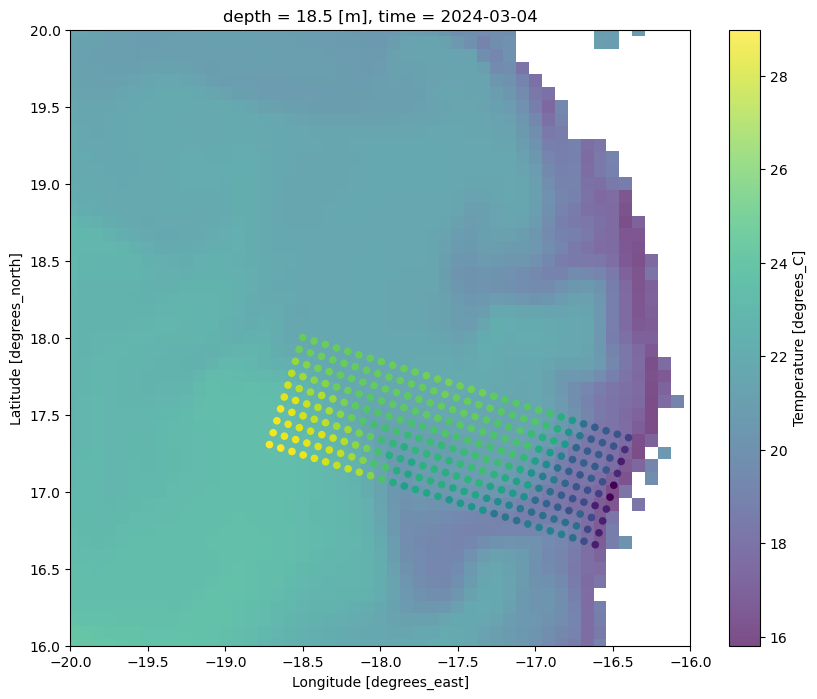

In [20]:
# Plot the extracted grid points for temperature data

fig, ax = plt.subplots(1,1, figsize=(10,8))

(temp
 .sel(time='2024-03-04')
 .sel(depth=20, method='nearest')
 .plot(alpha=0.7,ax=ax)
)

ax.set_xlim(-20, -16)
ax.set_ylim(16,20)

ax.scatter(x = ds_t.target_lon,
           y = ds_t.target_lat,
           c = ds_t.sel(time='2024-03-04').sel(depth=20, method='nearest'),
           s=20)

# plt.savefig('figure/temperature_rotated.jpg', dpi=600, bbox_inches='tight')

Text(0.5, 1.0, 'Rotated Wind Field')

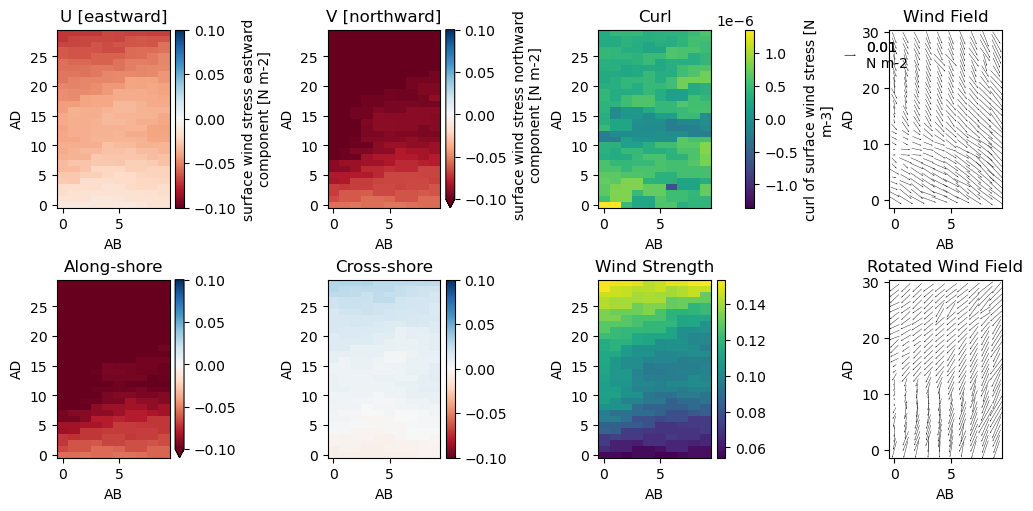

In [21]:
# Plot the extracted points for wind data and show the rotated field.

t='2024-03-04'

fig, ax = plt.subplots(2,4,figsize=(10,5), constrained_layout=True)
ax = ax.flatten()

u.sel(time=t).plot(ax=ax[0], cmap="RdBu", vmin=-0.1, vmax=0.1)
v.sel(time=t).plot(ax=ax[1], cmap="RdBu", vmin=-0.1, vmax=0.1)
ds_wind.stress_curl.sel(time=t).plot(ax=ax[2], cmap='viridis')
ds_wind.isel(time=0).plot.quiver(x='AB', y='AD', u='eastward_stress', v='northward_stress',ax=ax[3],scale=0.1)

along.sel(time=t).plot(ax=ax[4], cmap="RdBu", vmin=-0.1, vmax=0.1)
cross.sel(time=t).plot(ax=ax[5], cmap="RdBu", vmin=-0.1, vmax=0.1)
total.sel(time=t).plot(ax=ax[6], cmap='viridis')
ds_wind_rotated.isel(time=0).plot.quiver(x='AB', y='AD', u='along', v='cross',ax=ax[7],scale=0.1)

ax[0].set_title('U [eastward]')
ax[1].set_title('V [northward]')
ax[2].set_title('Curl')
ax[3].set_title('Wind Field')

ax[4].set_title('Along-shore')
ax[5].set_title('Cross-shore')
ax[6].set_title('Wind Strength')
ax[7].set_title('Rotated Wind Field')


# for i in ax:
#     i.set_aspect('equal')
# plt.savefig('figure/wind_rotation.jpg', dpi=600, bbox_inches='tight')

(16.0, 20.0)

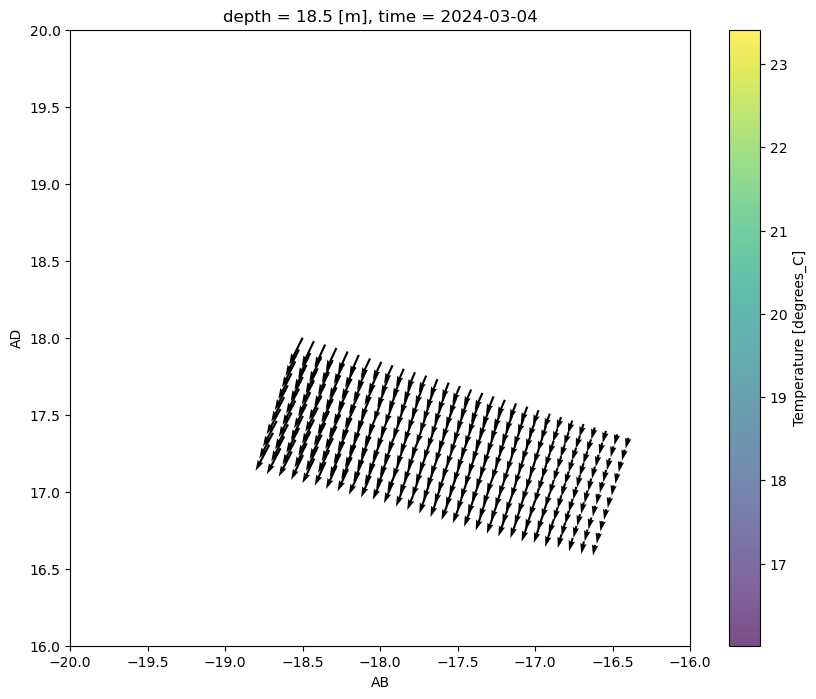

In [22]:
# plot the wind or rotated wind data
fig, ax = plt.subplots(1,1, figsize=(10,8))

(ds_t
 .sel(time='2024-03-04')
 .sel(depth=20, method='nearest')
 .plot(alpha=0.7,ax=ax)
)


# wind_plot = ds_wind_rotated.sel(time='2024-03-04')
# ax.quiver(wind_plot.target_lon,wind_plot.target_lat
#              ,wind_plot.along, wind_plot.cross)

wind_plot = ds_wind.sel(time='2024-03-04')
ax.quiver(wind_plot.target_lon,wind_plot.target_lat
             ,wind_plot.eastward_stress, wind_plot.northward_stress)

ax.set_xlim(-20, -16)
ax.set_ylim(16,20)

# plt.savefig('figure/wind_direction.jpg', dpi=600, bbox_inches='tight')